In [1]:
# General imports
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [2]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initialize Dataset
df = pd.read_csv("../Sentiment_IMDB_Dataset.csv")

# Initialize stopwords 
stopwords = stopwords.words('english')
stopwords.remove('not')

# Initialize stemmer and lemmatizer for text preprocessing
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [3]:
# Helper function to read the data over loops (solve out of memory problem)
def read_data(dataframe, start, end):
  df = dataframe[start : end]
  return df

# Helper function to clean text and split by words
def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text) # Remove non-letters
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra white spaces

    # Split words 
    words = re.split(r'\W+', text)
    # Stem, Lemmatize, and remove stopwords 
    words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words if word not in stopwords] 
    
    # return list of strings
    words = " ".join(words)
    
    return words

# Print Size of an np array
def print_size(data):
  size_in_bytes = data.nbytes
  size_in_megabytes = size_in_bytes / (1024**2)
  size_in_gigabytes = size_in_bytes / (1024**3)

  print(f"- Size of Corpus: {size_in_megabytes:.2f} MB - {size_in_gigabytes:.2f} GB")

In [4]:
# Clean Data
reviews = df['review'].apply( lambda review: clean_text(review) )

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize n_gram_vectorizer
n_gram_vectorizer = CountVectorizer(ngram_range=(1,2))

# Transform data into n_grams
transformed_reviews = n_gram_vectorizer.fit_transform(reviews)

print(f"Number of grams in vocabulary: {len(n_gram_vectorizer.vocabulary_)}")

Number of grams in vocabulary: 2641907


In [6]:
# Save tokenizer
import pickle
with open('../Models/1_2_gram_logistic_regression/1_2_gram_vectorizer.pkl', 'wb') as file:
  pickle.dump(n_gram_vectorizer, file)

print("Vectorizer Saved")

Vectorizer Saved


In [7]:
## Visualize the frequency of ngrams in our data (Most frequent vs least frequent)
# Sum the term frequencies across all reviews
word_counts = transformed_reviews.sum(axis=0).A1

# Get the vocabulary
vocab = n_gram_vectorizer.get_feature_names_out()

# Create a DataFrame with words and their corresponding frequencies
word_freq = pd.DataFrame({'word': vocab, 'frequency': word_counts})

# Sort the DataFrame by frequency in descending order
word_freq = word_freq.sort_values(by='frequency', ascending=False)

word_freq

,word,frequency
1524423,movi,103240
847835,film,95853
1596774,not,60763
1637720,one,55435
1332187,like,45197
...,...,...
1302645,leader endeavour,1
1302644,leader end,1
1302643,leader emotionless,1
1302642,leader el,1


In [8]:
# After cleaning and seeing the word_counts, replace the df's review column by our adjusted and cleaned reviews
df['review'] = reviews

# Label encode class label
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Initialize Logistic Regression model
LR = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1)

# Initialize thresholds to load data as batches of 100 reviews.
thresholds = range(100, 50000, 100)
iterator = 0

# Store classification metrics
accuracy_history = []
precision_history = []
recall_history = []
f1_history = []
roc_aucs_history = []

In [10]:
## Train model on batches of 100

for threshold in thresholds:
  # Load data
  start = threshold - 100
  data = read_data(dataframe=df, start=start, end=threshold)

  # Separate Data
  reviews = data['review']
  labels = data['sentiment']

  # Transform reviews to bag of 1_2_grams
  reviews = n_gram_vectorizer.transform(reviews).toarray()

  # Print size of the corpus
  print_size(data=reviews)

  # Split the batch of data
  X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, stratify=labels, shuffle=True)

  # Reshape labels
  y_train = np.reshape(y_train, (len(y_train),))
  y_test = np.reshape(y_test, (len(y_test),))

  # Train model on current batch
  LR.partial_fit(X_train, y_train, classes=np.array([0, 1]))
  
  # Predict
  y_pred = LR.predict(X_test)

  # Evaluate Predictions
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  iterator += 1
  print(f"LR: {iterator} - Threshold: {threshold} - Accuracy: {accuracy:.3f} - Precision: {precision:.3f} - Recall: {recall:.3f} - F1 Score: {f1:.3f} - ROC-AUC Score: {roc_auc:.3f}")

  # Store metrics for plotting
  accuracy_history.append(accuracy) 
  precision_history.append(precision)
  recall_history.append(recall)
  f1_history.append(f1)
  roc_aucs_history.append(roc_auc)

- Size of Corpus: 2015.62 MB - 1.97 GB
LR: 1 - Threshold: 100 - Accuracy: 0.550 - Precision: 0.467 - Recall: 0.875 - F1 Score: 0.609 - ROC-AUC Score: 0.604
- Size of Corpus: 2015.62 MB - 1.97 GB
LR: 2 - Threshold: 200 - Accuracy: 0.650 - Precision: 0.583 - Recall: 0.778 - F1 Score: 0.667 - ROC-AUC Score: 0.662
- Size of Corpus: 2015.62 MB - 1.97 GB


c:\Users\Dagher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LR: 3 - Threshold: 300 - Accuracy: 0.450 - Precision: 0.000 - Recall: 0.000 - F1 Score: 0.000 - ROC-AUC Score: 0.500
- Size of Corpus: 2015.62 MB - 1.97 GB
LR: 4 - Threshold: 400 - Accuracy: 0.600 - Precision: 1.000 - Recall: 0.200 - F1 Score: 0.333 - ROC-AUC Score: 0.600
- Size of Corpus: 2015.62 MB - 1.97 GB
LR: 5 - Threshold: 500 - Accuracy: 0.550 - Precision: 0.500 - Recall: 0.889 - F1 Score: 0.640 - ROC-AUC Score: 0.581
- Size of Corpus: 2015.62 MB - 1.97 GB
LR: 6 - Threshold: 600 - Accuracy: 0.500 - Precision: 0.444 - Recall: 0.444 - F1 Score: 0.444 - ROC-AUC Score: 0.495
- Size of Corpus: 2015.62 MB - 1.97 GB
LR: 7 - Threshold: 700 - Accuracy: 0.800 - Precision: 0.889 - Recall: 0.727 - F1 Score: 0.800 - ROC-AUC Score: 0.808
- Size of Corpus: 2015.62 MB - 1.97 GB
LR: 8 - Threshold: 800 - Accuracy: 0.700 - Precision: 0.625 - Recall: 1.000 - F1 Score: 0.769 - ROC-AUC Score: 0.700
- Size of Corpus: 2015.62 MB - 1.97 GB
LR: 9 - Threshold: 900 - Accuracy: 0.850 - Precision: 0.846 - Re

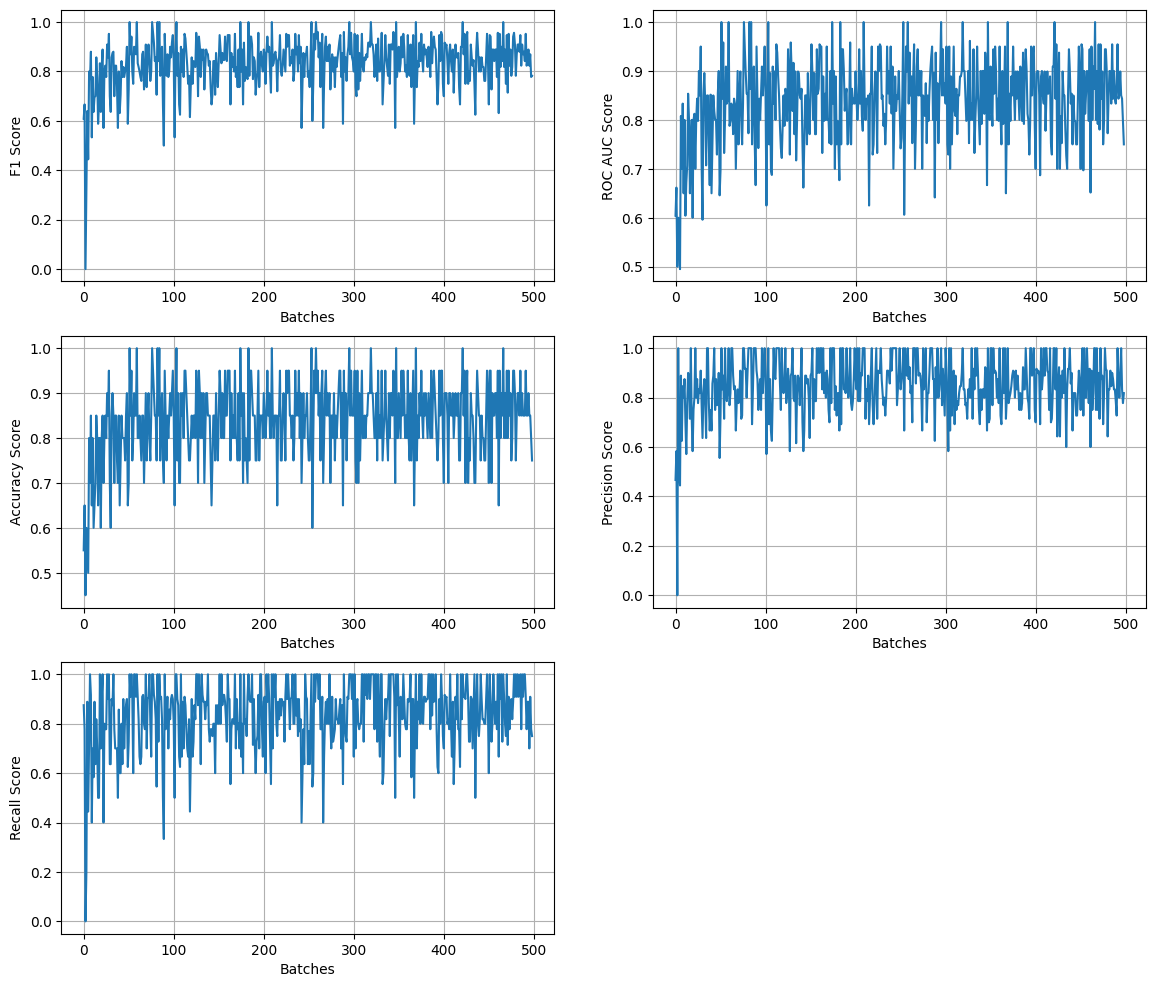

In [11]:
def add_subplot(axis, metric_history, title):
  axis.plot(metric_history)
  axis.set_xlabel("Batches")
  axis.set_ylabel(title)
  axis.grid(True)

fig, (ax1, ax2, ax3) = plt.subplots(3,2, figsize=(14, 12))

add_subplot(axis=ax1[0], metric_history=f1_history, title="F1 Score")
add_subplot(axis=ax1[1], metric_history=roc_aucs_history, title="ROC AUC Score")
add_subplot(axis=ax2[0], metric_history=accuracy_history, title="Accuracy Score")
add_subplot(axis=ax2[1], metric_history=precision_history, title="Precision Score")
add_subplot(axis=ax3[0], metric_history=recall_history, title="Recall Score")

fig.delaxes(ax3[1])

In [13]:
print(len(accuracy_history))

499


In [14]:
print(f"Mean accuracy: Last 100 Batches: {np.mean(accuracy_history[399:]):.2f} - Last 40 Batches: {np.mean(accuracy_history[459:]):.2f} - Last 20 Batches {np.mean(accuracy_history[479:]):.2f} ")

print(f"Mean precision: Last 100 Batches: {np.mean(precision_history[399:]):.2f} - Last 40 Batches: {np.mean(precision_history[459:]):.2f} - Last 20 Batches {np.mean(precision_history[479:]):.2f} ")

print(f"Mean recall: Last 100 Batches: {np.mean(recall_history[399:]):.2f} - Last 40 Batches: {np.mean(recall_history[459:]):.2f} - Last 20 Batches {np.mean(recall_history[479:]):.2f} ")

print(f"Mean f1: Last 100 Batches: {np.mean(f1_history[399:]):.2f} - Last 40 Batches: {np.mean(f1_history[459:]):.2f} - Last 20 Batches {np.mean(f1_history[479:]):.2f} ")

print(f"Mean roc_auc: Last 100 Batches: {np.mean(roc_aucs_history[399:]):.2f} - Last 40 Batches: {np.mean(roc_aucs_history[459:]):.2f} - Last 20 Batches {np.mean(roc_aucs_history[479:]):.2f} ")

print("Each batch is 250 reviews")

Mean accuracy: Last 100 Batches: 0.85 - Last 40 Batches: 0.86 - Last 20 Batches 0.86 
Mean precision: Last 100 Batches: 0.85 - Last 40 Batches: 0.85 - Last 20 Batches 0.85 
Mean recall: Last 100 Batches: 0.86 - Last 40 Batches: 0.88 - Last 20 Batches 0.90 
Mean f1: Last 100 Batches: 0.85 - Last 40 Batches: 0.86 - Last 20 Batches 0.86 
Mean roc_auc: Last 100 Batches: 0.85 - Last 40 Batches: 0.86 - Last 20 Batches 0.86 
Each batch is 250 reviews


In [15]:
print(f"Mean Accuracy: {np.mean(accuracy_history):.2f}")
print(f"Mean Precision: {np.mean(precision_history):.2f}")
print(f"Mean Recall: {np.mean(recall_history):.2f}")
print(f"Mean F1: {np.mean(f1_history):.2f}")
print(f"Mean ROC AUC: {np.mean(roc_aucs_history):.2f}")

Mean Accuracy: 0.84
Mean Precision: 0.85
Mean Recall: 0.84
Mean F1: 0.83
Mean ROC AUC: 0.84


In [16]:
import joblib
joblib.dump(LR, '../Models/1_2_gram_logistic_regression/1_2_gram_Logistic_Regression.pkl')

['../Models/1_2_gram_logistic_regression/1_2_gram_Logistic_Regression.pkl']